## libs

In [1]:
# python utils
import itertools
import inspect

# pre-processing and exploring data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.python.keras import utils
from tensorflow.keras import regularizers, optimizers

## Import Data

In [2]:
df = pd.read_csv('datasets/pima_indians_diabetes.csv', header=0)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Preprocessing Data

In [3]:
df['Outcome'] = df['Outcome'].factorize()[0]
df['Outcome'] = df['Outcome'].astype("category")
df.dtypes

Pregnancies                    int64
Glucose                        int64
BloodPressure                  int64
SkinThickness                  int64
Insulin                        int64
BMI                          float64
DiabetesPedigreeFunction     float64
Age                            int64
Outcome                     category
dtype: object

In [4]:
# split in input and output sets
input_df = df.drop("Outcome", axis=1)
output_df = df["Outcome"]

In [5]:
# normalizing values of input df between 0 and 1 (per column)
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

input_df = normalize(input_df)
input_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000


In [6]:
# split in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    input_df, output_df, test_size=0.15,
)

# One hot encode
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

In [7]:
print("X_train shape = {}".format(np.shape(X_train)))
print("y_train shape = {}".format(np.shape(y_train)))
print("X_test shape = {}".format(np.shape(X_test)))
print("y_test shape = {}".format(np.shape(y_test)))

X_train shape = (652, 8)
y_train shape = (652, 2)
X_test shape = (116, 8)
y_test shape = (116, 2)


## Model Builder

In [8]:
def mlp_momentum_l2_MSE_classifier_builder(
    input_layer, hidden_layers, output_layer, l2_value, momentum_beta
):
    model = Sequential()

    # first hidden layer
    model.add(
        Dense(
            hidden_layers[0],
            input_dim=input_layer,
            activation="relu",
            kernel_regularizer=regularizers.l2(l2_value),
            bias_regularizer=regularizers.l2(l2_value),
        )
    )

    # following hidden layers
    for hidden_layer in hidden_layers[1:]:
        model.add(
            Dense(
                hidden_layer,
                activation="relu",
                kernel_regularizer=regularizers.l2(l2_value),
                bias_regularizer=regularizers.l2(l2_value),
            )
        )

    # output layer
    model.add(Dense(output_layer, activation="softmax"))

    # create model
    model.compile(
        loss="mean_squared_error",
#         loss="categorical_crossentropy",
        optimizer=optimizers.SGD(learning_rate=0.01, momentum=momentum_beta),
#         optimizer='adam',
        metrics=["accuracy"],
    )

    return model


def build_models(builder_method, *args_tests):
    """
    Build models with all the combinations of the args_test passed
    """
    builder_args_names = list(inspect.signature(builder_method).parameters.keys())
    return [
        dict((("model", builder_method(*args)),) + tuple(zip(builder_args_names, args)))
        for args in itertools.product(*args_tests)
    ]

## Models Definition

In [12]:
# Parameters definition
input_layer_tests = [8]
hidden_layers_tests = [[4, 4], [32, 32], [128, 128]]
output_layer_tests = [2]
l2_value_tests = [0.1, 0.01, 0.001]
momentum_beta_tests = [0.8, 0.9, 0.99]

In [13]:
# building models with all the combinations of the test parameters
models = build_models(
    mlp_momentum_l2_MSE_classifier_builder,
    input_layer_tests,
    hidden_layers_tests,
    output_layer_tests,
    l2_value_tests,
    momentum_beta_tests,
)
models

[{'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f94b2b0d450>,
  'input_layer': 8,
  'hidden_layers': [4, 4],
  'output_layer': 2,
  'l2_value': 0.1,
  'momentum_beta': 0.8},
 {'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f94d7096850>,
  'input_layer': 8,
  'hidden_layers': [4, 4],
  'output_layer': 2,
  'l2_value': 0.1,
  'momentum_beta': 0.9},
 {'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f94b2711e90>,
  'input_layer': 8,
  'hidden_layers': [4, 4],
  'output_layer': 2,
  'l2_value': 0.1,
  'momentum_beta': 0.99},
 {'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f94b2657250>,
  'input_layer': 8,
  'hidden_layers': [4, 4],
  'output_layer': 2,
  'l2_value': 0.01,
  'momentum_beta': 0.8},
 {'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f94b252e1d0>,
  'input_layer': 8,
  'hidden_layers': [4, 4],
  'output_layer': 2,
  'l2_value': 0.01,
  'momentum_beta': 0.9},
 {'model': <

## Models Training

In [14]:
for model in models:
    model["results"] = model["model"].fit(
        X_train, y_train, epochs=500, batch_size=25
    )
    _, model["train_acc"] = model["model"].evaluate(X_train, y_train, verbose=0)
    _, model["test_acc"] = model["model"].evaluate(X_test, y_test, verbose=0)

Train on 652 samples
Epoch 1/500
652/652 [==============================] - 0s 115us/sample - loss: 1.0407 - accuracy: 0.6457
Epoch 2/500
652/652 [==============================] - 0s 34us/sample - loss: 0.6998 - accuracy: 0.6457
Epoch 3/500
652/652 [==============================] - 0s 33us/sample - loss: 0.4975 - accuracy: 0.6457
Epoch 4/500
652/652 [==============================] - 0s 34us/sample - loss: 0.3823 - accuracy: 0.6457
Epoch 5/500
652/652 [==============================] - 0s 34us/sample - loss: 0.3165 - accuracy: 0.6457
Epoch 6/500
652/652 [==============================] - 0s 38us/sample - loss: 0.2789 - accuracy: 0.6457
Epoch 7/500
652/652 [==============================] - 0s 36us/sample - loss: 0.2575 - accuracy: 0.6457
Epoch 8/500
652/652 [==============================] - 0s 37us/sample - loss: 0.2454 - accuracy: 0.6457
Epoch 9/500
652/652 [==============================] - 0s 35us/sample - loss: 0.2385 - accuracy: 0.6457
Epoch 10/500
652/652 [====================

652/652 [==============================] - 0s 33us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 78/500
652/652 [==============================] - 0s 31us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 79/500
652/652 [==============================] - 0s 32us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 80/500
652/652 [==============================] - 0s 32us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 81/500
652/652 [==============================] - 0s 31us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 82/500
652/652 [==============================] - 0s 34us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 83/500
652/652 [==============================] - 0s 35us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 84/500
652/652 [==============================] - 0s 31us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 85/500
652/652 [==============================] - 0s 37us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 86/500
652/652 [==============================] - 0s 32us/samp

652/652 [==============================] - 0s 33us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 155/500
652/652 [==============================] - 0s 33us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 156/500
652/652 [==============================] - 0s 34us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 157/500
652/652 [==============================] - 0s 37us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 158/500
652/652 [==============================] - 0s 30us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 159/500
652/652 [==============================] - 0s 31us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 160/500
652/652 [==============================] - 0s 29us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 161/500
652/652 [==============================] - 0s 34us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 162/500
652/652 [==============================] - 0s 32us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 163/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 34us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 232/500
652/652 [==============================] - 0s 34us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 233/500
652/652 [==============================] - 0s 33us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 234/500
652/652 [==============================] - 0s 31us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 235/500
652/652 [==============================] - 0s 37us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 236/500
652/652 [==============================] - 0s 33us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 237/500
652/652 [==============================] - 0s 36us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 238/500
652/652 [==============================] - 0s 34us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 239/500
652/652 [==============================] - 0s 34us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 240/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 33us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 309/500
652/652 [==============================] - 0s 29us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 310/500
652/652 [==============================] - 0s 30us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 311/500
652/652 [==============================] - 0s 31us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 312/500
652/652 [==============================] - 0s 33us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 313/500
652/652 [==============================] - 0s 32us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 314/500
652/652 [==============================] - 0s 30us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 315/500
652/652 [==============================] - 0s 32us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 316/500
652/652 [==============================] - 0s 36us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 317/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 31us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 386/500
652/652 [==============================] - 0s 31us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 387/500
652/652 [==============================] - 0s 30us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 388/500
652/652 [==============================] - 0s 30us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 389/500
652/652 [==============================] - 0s 31us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 390/500
652/652 [==============================] - 0s 31us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 391/500
652/652 [==============================] - 0s 30us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 392/500
652/652 [==============================] - 0s 31us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 393/500
652/652 [==============================] - 0s 30us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 394/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 31us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 463/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 464/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 465/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 466/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 467/500
652/652 [==============================] - 0s 38us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 468/500
652/652 [==============================] - 0s 33us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 469/500
652/652 [==============================] - 0s 34us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 470/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 471/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 37us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 35/500
652/652 [==============================] - 0s 31us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 36/500
652/652 [==============================] - 0s 36us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 37/500
652/652 [==============================] - 0s 34us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 38/500
652/652 [==============================] - 0s 33us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 39/500
652/652 [==============================] - 0s 36us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 40/500
652/652 [==============================] - 0s 31us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 41/500
652/652 [==============================] - 0s 35us/sample - loss: 0.2287 - accuracy: 0.6457
Epoch 42/500
652/652 [==============================] - 0s 32us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 43/500
652/652 [==============================] - 0s 31us/samp

652/652 [==============================] - 0s 31us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 113/500
652/652 [==============================] - 0s 31us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 114/500
652/652 [==============================] - 0s 29us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 115/500
652/652 [==============================] - 0s 32us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 116/500
652/652 [==============================] - 0s 30us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 117/500
652/652 [==============================] - 0s 32us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 118/500
652/652 [==============================] - 0s 34us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 119/500
652/652 [==============================] - 0s 32us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 120/500
652/652 [==============================] - 0s 35us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 121/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 33us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 190/500
652/652 [==============================] - 0s 35us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 191/500
652/652 [==============================] - 0s 34us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 192/500
652/652 [==============================] - 0s 30us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 193/500
652/652 [==============================] - 0s 32us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 194/500
652/652 [==============================] - 0s 33us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 195/500
652/652 [==============================] - 0s 31us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 196/500
652/652 [==============================] - 0s 31us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 197/500
652/652 [==============================] - 0s 35us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 198/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 36us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 267/500
652/652 [==============================] - 0s 31us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 268/500
652/652 [==============================] - 0s 31us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 269/500
652/652 [==============================] - 0s 35us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 270/500
652/652 [==============================] - 0s 32us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 271/500
652/652 [==============================] - 0s 31us/sample - loss: 0.2287 - accuracy: 0.6457
Epoch 272/500
652/652 [==============================] - 0s 36us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 273/500
652/652 [==============================] - 0s 32us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 274/500
652/652 [==============================] - 0s 33us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 275/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 34us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 344/500
652/652 [==============================] - 0s 31us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 345/500
652/652 [==============================] - 0s 36us/sample - loss: 0.2287 - accuracy: 0.6457
Epoch 346/500
652/652 [==============================] - 0s 32us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 347/500
652/652 [==============================] - 0s 32us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 348/500
652/652 [==============================] - 0s 34us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 349/500
652/652 [==============================] - 0s 32us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 350/500
652/652 [==============================] - 0s 33us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 351/500
652/652 [==============================] - 0s 34us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 352/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 34us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 420/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 421/500
652/652 [==============================] - 0s 37us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 422/500
652/652 [==============================] - 0s 32us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 423/500
652/652 [==============================] - 0s 32us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 424/500
652/652 [==============================] - 0s 36us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 425/500
652/652 [==============================] - 0s 32us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 426/500
652/652 [==============================] - 0s 35us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 427/500
652/652 [==============================] - 0s 33us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 428/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 33us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 497/500
652/652 [==============================] - 0s 35us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 498/500
652/652 [==============================] - 0s 31us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 499/500
652/652 [==============================] - 0s 35us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 500/500
652/652 [==============================] - 0s 32us/sample - loss: 0.2291 - accuracy: 0.6457
Train on 652 samples
Epoch 1/500
652/652 [==============================] - 0s 93us/sample - loss: 0.8397 - accuracy: 0.6457
Epoch 2/500
652/652 [==============================] - 0s 30us/sample - loss: 0.2959 - accuracy: 0.6457
Epoch 3/500
652/652 [==============================] - 0s 28us/sample - loss: 0.6163 - accuracy: 0.6442
Epoch 4/500
652/652 [==============================] - 0s 24us/sample - loss: 0.3928 - accuracy: 0.6457
Epoch 5/500
652/652 [==========================

652/652 [==============================] - 0s 42us/sample - loss: 0.2302 - accuracy: 0.6457
Epoch 69/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2297 - accuracy: 0.6457
Epoch 70/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2327 - accuracy: 0.6457
Epoch 71/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2336 - accuracy: 0.6457
Epoch 72/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2309 - accuracy: 0.6457
Epoch 73/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2324 - accuracy: 0.6457
Epoch 74/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2331 - accuracy: 0.6457
Epoch 75/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2303 - accuracy: 0.6457
Epoch 76/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2296 - accuracy: 0.6457
Epoch 77/500
652/652 [==============================] - 0s 43us/samp

652/652 [==============================] - 0s 46us/sample - loss: 0.2296 - accuracy: 0.6457
Epoch 146/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2293 - accuracy: 0.6457
Epoch 147/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 148/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 149/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2293 - accuracy: 0.6457
Epoch 150/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 151/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 152/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2296 - accuracy: 0.6457
Epoch 153/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 154/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 43us/sample - loss: 0.2301 - accuracy: 0.6457
Epoch 223/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2293 - accuracy: 0.6457
Epoch 224/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 225/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2295 - accuracy: 0.6457
Epoch 226/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 227/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 228/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2293 - accuracy: 0.6457
Epoch 229/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 230/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 231/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 41us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 300/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 301/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 302/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2296 - accuracy: 0.6457
Epoch 303/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2296 - accuracy: 0.6457
Epoch 304/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 305/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2308 - accuracy: 0.6457
Epoch 306/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2298 - accuracy: 0.6457
Epoch 307/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2310 - accuracy: 0.6457
Epoch 308/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 41us/sample - loss: 0.2296 - accuracy: 0.6457
Epoch 377/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 378/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2297 - accuracy: 0.6457
Epoch 379/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 380/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 381/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 382/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 383/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 384/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 385/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 42us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 454/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2294 - accuracy: 0.6457
Epoch 455/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 456/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 457/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 458/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 459/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2287 - accuracy: 0.6457
Epoch 460/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2307 - accuracy: 0.6457
Epoch 461/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2308 - accuracy: 0.6457
Epoch 462/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 41us/sample - loss: 0.2499 - accuracy: 0.6457
Epoch 26/500
652/652 [==============================] - 0s 38us/sample - loss: 0.2487 - accuracy: 0.6457
Epoch 27/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2478 - accuracy: 0.6457
Epoch 28/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2468 - accuracy: 0.6457
Epoch 29/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2457 - accuracy: 0.6457
Epoch 30/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2448 - accuracy: 0.6457
Epoch 31/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2440 - accuracy: 0.6457
Epoch 32/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2435 - accuracy: 0.6457
Epoch 33/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2425 - accuracy: 0.6457
Epoch 34/500
652/652 [==============================] - 0s 41us/samp

652/652 [==============================] - 0s 41us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 104/500
652/652 [==============================] - 0s 38us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 105/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 106/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 107/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 108/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 109/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 110/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 111/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 112/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 48us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 181/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 182/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 183/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 184/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 185/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 186/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 187/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 188/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 189/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 38us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 258/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 259/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 260/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 261/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 262/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 263/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 264/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 265/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 266/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 41us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 335/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 336/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 337/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 338/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 339/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 340/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 341/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 342/500
652/652 [==============================] - 0s 38us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 343/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 41us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 412/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 413/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 414/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 415/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 416/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 417/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 418/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 419/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 420/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 41us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 489/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 490/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 491/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 492/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 493/500
652/652 [==============================] - 0s 59us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 494/500
652/652 [==============================] - 0s 63us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 495/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 496/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 497/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 35us/sample - loss: 0.1930 - accuracy: 0.7730
Epoch 61/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1947 - accuracy: 0.7638
Epoch 62/500
652/652 [==============================] - 0s 35us/sample - loss: 0.1943 - accuracy: 0.7730
Epoch 63/500
652/652 [==============================] - 0s 38us/sample - loss: 0.1939 - accuracy: 0.7715
Epoch 64/500
652/652 [==============================] - 0s 35us/sample - loss: 0.1916 - accuracy: 0.7592
Epoch 65/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1961 - accuracy: 0.7500
Epoch 66/500
652/652 [==============================] - 0s 35us/sample - loss: 0.1927 - accuracy: 0.7699
Epoch 67/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1903 - accuracy: 0.7761
Epoch 68/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1914 - accuracy: 0.7623
Epoch 69/500
652/652 [==============================] - 0s 40us/samp

652/652 [==============================] - 0s 43us/sample - loss: 0.1855 - accuracy: 0.7715
Epoch 138/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1915 - accuracy: 0.7561
Epoch 139/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1817 - accuracy: 0.7715
Epoch 140/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1847 - accuracy: 0.7699
Epoch 141/500
652/652 [==============================] - ETA: 0s - loss: 0.1486 - accuracy: 0.92 - 0s 40us/sample - loss: 0.1831 - accuracy: 0.7745
Epoch 142/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1890 - accuracy: 0.7561
Epoch 143/500
652/652 [==============================] - ETA: 0s - loss: 0.1155 - accuracy: 0.92 - 0s 44us/sample - loss: 0.1874 - accuracy: 0.7623
Epoch 144/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1880 - accuracy: 0.7592
Epoch 145/500
652/652 [==============================] - 0s 40us/sample - loss: 0.

652/652 [==============================] - 0s 40us/sample - loss: 0.1905 - accuracy: 0.7469
Epoch 214/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1790 - accuracy: 0.7607
Epoch 215/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1787 - accuracy: 0.7715
Epoch 216/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1861 - accuracy: 0.7531
Epoch 217/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1828 - accuracy: 0.7684
Epoch 218/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1818 - accuracy: 0.7623
Epoch 219/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1792 - accuracy: 0.7745
Epoch 220/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1796 - accuracy: 0.7669
Epoch 221/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1795 - accuracy: 0.7684
Epoch 222/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 40us/sample - loss: 0.1784 - accuracy: 0.7745
Epoch 291/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1805 - accuracy: 0.7669
Epoch 292/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1778 - accuracy: 0.7653
Epoch 293/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1789 - accuracy: 0.7607
Epoch 294/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1810 - accuracy: 0.7623
Epoch 295/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1817 - accuracy: 0.7577
Epoch 296/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1842 - accuracy: 0.7699
Epoch 297/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1808 - accuracy: 0.7638
Epoch 298/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1831 - accuracy: 0.7623
Epoch 299/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 38us/sample - loss: 0.1770 - accuracy: 0.7791
Epoch 368/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1791 - accuracy: 0.7469
Epoch 369/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1841 - accuracy: 0.7577
Epoch 370/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1759 - accuracy: 0.7715
Epoch 371/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1770 - accuracy: 0.7684
Epoch 372/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1900 - accuracy: 0.7500
Epoch 373/500
652/652 [==============================] - 0s 37us/sample - loss: 0.1789 - accuracy: 0.7730
Epoch 374/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1824 - accuracy: 0.7546
Epoch 375/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1836 - accuracy: 0.7684
Epoch 376/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 40us/sample - loss: 0.1784 - accuracy: 0.7699
Epoch 445/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1773 - accuracy: 0.7684
Epoch 446/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1834 - accuracy: 0.7684
Epoch 447/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1768 - accuracy: 0.7776
Epoch 448/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1813 - accuracy: 0.7684
Epoch 449/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1863 - accuracy: 0.7331
Epoch 450/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1754 - accuracy: 0.7715
Epoch 451/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1774 - accuracy: 0.7669
Epoch 452/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1805 - accuracy: 0.7623
Epoch 453/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 41us/sample - loss: 0.2300 - accuracy: 0.6457
Epoch 17/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2302 - accuracy: 0.6457
Epoch 18/500
652/652 [==============================] - 0s 38us/sample - loss: 0.2300 - accuracy: 0.6457
Epoch 19/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2299 - accuracy: 0.6457
Epoch 20/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2296 - accuracy: 0.6457
Epoch 21/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2302 - accuracy: 0.6457
Epoch 22/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 23/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2301 - accuracy: 0.6457
Epoch 24/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2293 - accuracy: 0.6457
Epoch 25/500
652/652 [==============================] - 0s 41us/samp

652/652 [==============================] - 0s 39us/sample - loss: 0.2284 - accuracy: 0.6457
Epoch 95/500
652/652 [==============================] - 0s 38us/sample - loss: 0.2304 - accuracy: 0.6457
Epoch 96/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2303 - accuracy: 0.6457
Epoch 97/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 98/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2296 - accuracy: 0.6457
Epoch 99/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 100/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 101/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2294 - accuracy: 0.6457
Epoch 102/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2299 - accuracy: 0.6457
Epoch 103/500
652/652 [==============================] - 0s 41us/

652/652 [==============================] - 0s 42us/sample - loss: 0.2298 - accuracy: 0.6457
Epoch 172/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 173/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 174/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2300 - accuracy: 0.6457
Epoch 175/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 176/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2295 - accuracy: 0.6457
Epoch 177/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2295 - accuracy: 0.6457
Epoch 178/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 179/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2296 - accuracy: 0.6457
Epoch 180/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 40us/sample - loss: 0.2295 - accuracy: 0.6457
Epoch 249/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 250/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2287 - accuracy: 0.6457
Epoch 251/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2303 - accuracy: 0.6457
Epoch 252/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2296 - accuracy: 0.6457
Epoch 253/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 254/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2298 - accuracy: 0.6457
Epoch 255/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 256/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 257/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 40us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 326/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 327/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2296 - accuracy: 0.6457
Epoch 328/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2294 - accuracy: 0.6457
Epoch 329/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 330/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 331/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 332/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2300 - accuracy: 0.6457
Epoch 333/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2299 - accuracy: 0.6457
Epoch 334/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 44us/sample - loss: 0.2284 - accuracy: 0.6457
Epoch 403/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2303 - accuracy: 0.6457
Epoch 404/500
652/652 [==============================] - 0s 38us/sample - loss: 0.2297 - accuracy: 0.6457
Epoch 405/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2318 - accuracy: 0.6457
Epoch 406/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2299 - accuracy: 0.6457
Epoch 407/500
652/652 [==============================] - 0s 38us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 408/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2303 - accuracy: 0.6457
Epoch 409/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2287 - accuracy: 0.6457
Epoch 410/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2305 - accuracy: 0.6457
Epoch 411/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 42us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 480/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 481/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 482/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2287 - accuracy: 0.6457
Epoch 483/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2295 - accuracy: 0.6457
Epoch 484/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2297 - accuracy: 0.6457
Epoch 485/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 486/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 487/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 488/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 40us/sample - loss: 0.1939 - accuracy: 0.7393
Epoch 52/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1926 - accuracy: 0.7347
Epoch 53/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1921 - accuracy: 0.7301
Epoch 54/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1907 - accuracy: 0.7393
Epoch 55/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1900 - accuracy: 0.7377
Epoch 56/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1889 - accuracy: 0.7500
Epoch 57/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1891 - accuracy: 0.7347
Epoch 58/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1879 - accuracy: 0.7577
Epoch 59/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1863 - accuracy: 0.7408
Epoch 60/500
652/652 [==============================] - 0s 40us/samp

652/652 [==============================] - 0s 42us/sample - loss: 0.1654 - accuracy: 0.7684
Epoch 129/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1639 - accuracy: 0.7715
Epoch 130/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1643 - accuracy: 0.7638
Epoch 131/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1653 - accuracy: 0.7684
Epoch 132/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1641 - accuracy: 0.7730
Epoch 133/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1651 - accuracy: 0.7669
Epoch 134/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1655 - accuracy: 0.7776
Epoch 135/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1636 - accuracy: 0.7684
Epoch 136/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1640 - accuracy: 0.7745
Epoch 137/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 41us/sample - loss: 0.1620 - accuracy: 0.7715
Epoch 206/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1614 - accuracy: 0.7776
Epoch 207/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1607 - accuracy: 0.7776
Epoch 208/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1610 - accuracy: 0.7669
Epoch 209/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1633 - accuracy: 0.7914
Epoch 210/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1597 - accuracy: 0.7776
Epoch 211/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1592 - accuracy: 0.7822
Epoch 212/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1590 - accuracy: 0.7761
Epoch 213/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1598 - accuracy: 0.7853
Epoch 214/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 43us/sample - loss: 0.1562 - accuracy: 0.7761
Epoch 283/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1560 - accuracy: 0.7791
Epoch 284/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1561 - accuracy: 0.7853
Epoch 285/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1568 - accuracy: 0.7791
Epoch 286/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1584 - accuracy: 0.7807
Epoch 287/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1577 - accuracy: 0.7807
Epoch 288/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1564 - accuracy: 0.7699
Epoch 289/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1571 - accuracy: 0.7638
Epoch 290/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1604 - accuracy: 0.7669
Epoch 291/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 40us/sample - loss: 0.1539 - accuracy: 0.7822
Epoch 360/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1538 - accuracy: 0.7791
Epoch 361/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1537 - accuracy: 0.7899
Epoch 362/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1536 - accuracy: 0.7853
Epoch 363/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1531 - accuracy: 0.7791
Epoch 364/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1541 - accuracy: 0.7914
Epoch 365/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1538 - accuracy: 0.7914
Epoch 366/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1533 - accuracy: 0.7853
Epoch 367/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1545 - accuracy: 0.7807
Epoch 368/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 42us/sample - loss: 0.1529 - accuracy: 0.7929
Epoch 437/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1527 - accuracy: 0.7745
Epoch 438/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1561 - accuracy: 0.7807
Epoch 439/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1535 - accuracy: 0.7776
Epoch 440/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1553 - accuracy: 0.7822
Epoch 441/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1538 - accuracy: 0.7868
Epoch 442/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1530 - accuracy: 0.7745
Epoch 443/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1519 - accuracy: 0.7853
Epoch 444/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1526 - accuracy: 0.7822
Epoch 445/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 39us/sample - loss: 0.2385 - accuracy: 0.6457
Epoch 9/500
652/652 [==============================] - 0s 35us/sample - loss: 0.2385 - accuracy: 0.6457
Epoch 10/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2386 - accuracy: 0.6457
Epoch 11/500
652/652 [==============================] - 0s 38us/sample - loss: 0.2382 - accuracy: 0.6457
Epoch 12/500
652/652 [==============================] - 0s 38us/sample - loss: 0.2381 - accuracy: 0.6457
Epoch 13/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2375 - accuracy: 0.6457
Epoch 14/500
652/652 [==============================] - 0s 37us/sample - loss: 0.2374 - accuracy: 0.6457
Epoch 15/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2374 - accuracy: 0.6457
Epoch 16/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2370 - accuracy: 0.6457
Epoch 17/500
652/652 [==============================] - 0s 38us/sampl

652/652 [==============================] - 0s 43us/sample - loss: 0.1707 - accuracy: 0.7653
Epoch 87/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1695 - accuracy: 0.7699
Epoch 88/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1691 - accuracy: 0.7653
Epoch 89/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1699 - accuracy: 0.7715
Epoch 90/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1684 - accuracy: 0.7730
Epoch 91/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1681 - accuracy: 0.7653
Epoch 92/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1685 - accuracy: 0.7745
Epoch 93/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1676 - accuracy: 0.7623
Epoch 94/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1673 - accuracy: 0.7776
Epoch 95/500
652/652 [==============================] - 0s 39us/samp

652/652 [==============================] - 0s 40us/sample - loss: 0.1611 - accuracy: 0.7853
Epoch 164/500
652/652 [==============================] - 0s 37us/sample - loss: 0.1632 - accuracy: 0.7684
Epoch 165/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1610 - accuracy: 0.7960
Epoch 166/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1681 - accuracy: 0.7715
Epoch 167/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1678 - accuracy: 0.7638
Epoch 168/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1617 - accuracy: 0.7945
Epoch 169/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1617 - accuracy: 0.7745
Epoch 170/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1613 - accuracy: 0.7715
Epoch 171/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1615 - accuracy: 0.7715
Epoch 172/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 39us/sample - loss: 0.1646 - accuracy: 0.7776
Epoch 241/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1604 - accuracy: 0.7791
Epoch 242/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1611 - accuracy: 0.7715
Epoch 243/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1628 - accuracy: 0.7791
Epoch 244/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1635 - accuracy: 0.7684
Epoch 245/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1616 - accuracy: 0.7699
Epoch 246/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1611 - accuracy: 0.7761
Epoch 247/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1597 - accuracy: 0.7669
Epoch 248/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1632 - accuracy: 0.7638
Epoch 249/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 42us/sample - loss: 0.1690 - accuracy: 0.7623
Epoch 318/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1590 - accuracy: 0.7853
Epoch 319/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1672 - accuracy: 0.7653
Epoch 320/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1604 - accuracy: 0.7653
Epoch 321/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1592 - accuracy: 0.7791
Epoch 322/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1582 - accuracy: 0.7776
Epoch 323/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1618 - accuracy: 0.7715
Epoch 324/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1596 - accuracy: 0.7715
Epoch 325/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1599 - accuracy: 0.7730
Epoch 326/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 43us/sample - loss: 0.1589 - accuracy: 0.7776
Epoch 395/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1587 - accuracy: 0.7822
Epoch 396/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1648 - accuracy: 0.7699
Epoch 397/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1642 - accuracy: 0.7715
Epoch 398/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1642 - accuracy: 0.7715
Epoch 399/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1599 - accuracy: 0.7776
Epoch 400/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1598 - accuracy: 0.7745
Epoch 401/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1604 - accuracy: 0.7623
Epoch 402/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1589 - accuracy: 0.7791
Epoch 403/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 40us/sample - loss: 0.1628 - accuracy: 0.7684
Epoch 472/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1608 - accuracy: 0.7776
Epoch 473/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1584 - accuracy: 0.7730
Epoch 474/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1602 - accuracy: 0.7715
Epoch 475/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1578 - accuracy: 0.7699
Epoch 476/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1638 - accuracy: 0.7669
Epoch 477/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1617 - accuracy: 0.7715
Epoch 478/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1699 - accuracy: 0.7592
Epoch 479/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1632 - accuracy: 0.7699
Epoch 480/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 43us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 44/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 45/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2302 - accuracy: 0.6457
Epoch 46/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2299 - accuracy: 0.6457
Epoch 47/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 48/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 49/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 50/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 51/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 52/500
652/652 [==============================] - 0s 44us/samp

652/652 [==============================] - 0s 43us/sample - loss: 0.2293 - accuracy: 0.6457
Epoch 121/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 122/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2287 - accuracy: 0.6457
Epoch 123/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 124/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2295 - accuracy: 0.6457
Epoch 125/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 126/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2294 - accuracy: 0.6457
Epoch 127/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2287 - accuracy: 0.6457
Epoch 128/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 129/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 41us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 198/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 199/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2298 - accuracy: 0.6457
Epoch 200/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2302 - accuracy: 0.6457
Epoch 201/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2307 - accuracy: 0.6457
Epoch 202/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2294 - accuracy: 0.6457
Epoch 203/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2294 - accuracy: 0.6457
Epoch 204/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2313 - accuracy: 0.6457
Epoch 205/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2298 - accuracy: 0.6457
Epoch 206/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 41us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 275/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 276/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 277/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2294 - accuracy: 0.6457
Epoch 278/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2304 - accuracy: 0.6457
Epoch 279/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2294 - accuracy: 0.6457
Epoch 280/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2296 - accuracy: 0.6457
Epoch 281/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2301 - accuracy: 0.6457
Epoch 282/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2306 - accuracy: 0.6457
Epoch 283/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 41us/sample - loss: 0.2293 - accuracy: 0.6457
Epoch 352/500
652/652 [==============================] - 0s 38us/sample - loss: 0.2294 - accuracy: 0.6457
Epoch 353/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2287 - accuracy: 0.6457
Epoch 354/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 355/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 356/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2293 - accuracy: 0.6457
Epoch 357/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 358/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2298 - accuracy: 0.6457
Epoch 359/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2294 - accuracy: 0.6457
Epoch 360/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 41us/sample - loss: 0.2287 - accuracy: 0.6457
Epoch 429/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 430/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 431/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 432/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 433/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 434/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 435/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2286 - accuracy: 0.6457
Epoch 436/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 437/500
652/652 [==============================] - 0s 

Train on 652 samples
Epoch 1/500
652/652 [==============================] - 0s 121us/sample - loss: 4.0976 - accuracy: 0.5046
Epoch 2/500
652/652 [==============================] - 0s 33us/sample - loss: 2.4582 - accuracy: 0.6457
Epoch 3/500
652/652 [==============================] - 0s 30us/sample - loss: 1.4946 - accuracy: 0.6457
Epoch 4/500
652/652 [==============================] - 0s 33us/sample - loss: 0.9479 - accuracy: 0.6457
Epoch 5/500
652/652 [==============================] - 0s 30us/sample - loss: 0.6376 - accuracy: 0.6457
Epoch 6/500
652/652 [==============================] - 0s 32us/sample - loss: 0.4612 - accuracy: 0.6457
Epoch 7/500
652/652 [==============================] - 0s 34us/sample - loss: 0.3611 - accuracy: 0.6457
Epoch 8/500
652/652 [==============================] - 0s 34us/sample - loss: 0.3042 - accuracy: 0.6457
Epoch 9/500
652/652 [==============================] - 0s 36us/sample - loss: 0.2717 - accuracy: 0.6457
Epoch 10/500
652/652 [====================

652/652 [==============================] - 0s 45us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 79/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 80/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 81/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 82/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 83/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 84/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 85/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 86/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 87/500
652/652 [==============================] - 0s 41us/samp

652/652 [==============================] - 0s 43us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 156/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 157/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 158/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 159/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 160/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 161/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 162/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 163/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 164/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 43us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 233/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 234/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 235/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 236/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 237/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 238/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 239/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 240/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 241/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 43us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 310/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 311/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 312/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 313/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 314/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 315/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 316/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 317/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 318/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 43us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 387/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 388/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 389/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 390/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 391/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 392/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 393/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 394/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 395/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 464/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 465/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 466/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 467/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 468/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 469/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 470/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 471/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 472/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 43us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 36/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 37/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 38/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 39/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 40/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 41/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 42/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2293 - accuracy: 0.6457
Epoch 43/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 44/500
652/652 [==============================] - 0s 40us/samp

652/652 [==============================] - 0s 42us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 114/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 115/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 116/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 117/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 118/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 119/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 120/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 121/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 122/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 43us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 190/500
652/652 [==============================] - 0s 38us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 191/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 192/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 193/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 194/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 195/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 196/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 197/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 198/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 43us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 267/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 268/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 269/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 270/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 271/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 272/500
652/652 [==============================] - 0s 38us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 273/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 274/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 275/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 43us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 344/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 345/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 346/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 347/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 348/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 349/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2287 - accuracy: 0.6457
Epoch 350/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 351/500
652/652 [==============================] - 0s 38us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 352/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 42us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 421/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 422/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 423/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 424/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 425/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 426/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 427/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 428/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 429/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 43us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 498/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 499/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 500/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2288 - accuracy: 0.6457
Train on 652 samples
Epoch 1/500
652/652 [==============================] - 0s 116us/sample - loss: 3.1706 - accuracy: 0.6074
Epoch 2/500
652/652 [==============================] - 0s 33us/sample - loss: 0.5613 - accuracy: 0.6457
Epoch 3/500
652/652 [==============================] - 0s 31us/sample - loss: 2.1071 - accuracy: 0.6457
Epoch 4/500
652/652 [==============================] - 0s 35us/sample - loss: 0.9317 - accuracy: 0.6457
Epoch 5/500
652/652 [==============================] - 0s 33us/sample - loss: 0.6458 - accuracy: 0.6457
Epoch 6/500
652/652 [===========================

652/652 [==============================] - 0s 43us/sample - loss: 0.2297 - accuracy: 0.6457
Epoch 70/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2296 - accuracy: 0.6457
Epoch 71/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2298 - accuracy: 0.6457
Epoch 72/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2297 - accuracy: 0.6457
Epoch 73/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2298 - accuracy: 0.6457
Epoch 74/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2293 - accuracy: 0.6457
Epoch 75/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2293 - accuracy: 0.6457
Epoch 76/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2294 - accuracy: 0.6457
Epoch 77/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2303 - accuracy: 0.6457
Epoch 78/500
652/652 [==============================] - 0s 41us/samp

652/652 [==============================] - 0s 40us/sample - loss: 0.2298 - accuracy: 0.6457
Epoch 147/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 148/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 149/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 150/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2294 - accuracy: 0.6457
Epoch 151/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2296 - accuracy: 0.6457
Epoch 152/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2298 - accuracy: 0.6457
Epoch 153/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 154/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2299 - accuracy: 0.6457
Epoch 155/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 43us/sample - loss: 0.2301 - accuracy: 0.6457
Epoch 224/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2299 - accuracy: 0.6457
Epoch 225/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2296 - accuracy: 0.6457
Epoch 226/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2293 - accuracy: 0.6457
Epoch 227/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2299 - accuracy: 0.6457
Epoch 228/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 229/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2295 - accuracy: 0.6457
Epoch 230/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2295 - accuracy: 0.6457
Epoch 231/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2299 - accuracy: 0.6457
Epoch 232/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 40us/sample - loss: 0.2300 - accuracy: 0.6457
Epoch 301/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 302/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 303/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 304/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2307 - accuracy: 0.6457
Epoch 305/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2303 - accuracy: 0.6457
Epoch 306/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2296 - accuracy: 0.6457
Epoch 307/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2293 - accuracy: 0.6457
Epoch 308/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 309/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 39us/sample - loss: 0.2297 - accuracy: 0.6457
Epoch 378/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2296 - accuracy: 0.6457
Epoch 379/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 380/500
652/652 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 0.84 - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 381/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 382/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 383/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 384/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 385/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2299 - accuracy: 0.6457
Epoch 386/500
652/

652/652 [==============================] - 0s 36us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 453/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 454/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2296 - accuracy: 0.6457
Epoch 455/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 456/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2295 - accuracy: 0.6457
Epoch 457/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2297 - accuracy: 0.6457
Epoch 458/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2283 - accuracy: 0.6457
Epoch 459/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2305 - accuracy: 0.6457
Epoch 460/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2302 - accuracy: 0.6457
Epoch 461/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 42us/sample - loss: 0.3409 - accuracy: 0.6994
Epoch 25/500
652/652 [==============================] - 0s 39us/sample - loss: 0.3327 - accuracy: 0.7025
Epoch 26/500
652/652 [==============================] - 0s 39us/sample - loss: 0.3273 - accuracy: 0.7009
Epoch 27/500
652/652 [==============================] - 0s 41us/sample - loss: 0.3190 - accuracy: 0.6963
Epoch 28/500
652/652 [==============================] - 0s 40us/sample - loss: 0.3126 - accuracy: 0.7055
Epoch 29/500
652/652 [==============================] - 0s 40us/sample - loss: 0.3065 - accuracy: 0.7163
Epoch 30/500
652/652 [==============================] - 0s 44us/sample - loss: 0.3015 - accuracy: 0.7255
Epoch 31/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2960 - accuracy: 0.7193
Epoch 32/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2909 - accuracy: 0.7117
Epoch 33/500
652/652 [==============================] - 0s 43us/samp

Epoch 101/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1964 - accuracy: 0.7546
Epoch 102/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1969 - accuracy: 0.7623
Epoch 103/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1941 - accuracy: 0.7669
Epoch 104/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1940 - accuracy: 0.7730
Epoch 105/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1929 - accuracy: 0.7745
Epoch 106/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1931 - accuracy: 0.7684
Epoch 107/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1923 - accuracy: 0.7730
Epoch 108/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1935 - accuracy: 0.7669
Epoch 109/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1930 - accuracy: 0.7730
Epoch 110/500
652/652 [=======================

652/652 [==============================] - 0s 45us/sample - loss: 0.1868 - accuracy: 0.7699
Epoch 178/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1876 - accuracy: 0.7653
Epoch 179/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1864 - accuracy: 0.7592
Epoch 180/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1878 - accuracy: 0.7761
Epoch 181/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1891 - accuracy: 0.7592
Epoch 182/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1889 - accuracy: 0.7577
Epoch 183/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1860 - accuracy: 0.7730
Epoch 184/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1857 - accuracy: 0.7623
Epoch 185/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1878 - accuracy: 0.7515
Epoch 186/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 41us/sample - loss: 0.1848 - accuracy: 0.7684
Epoch 255/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1830 - accuracy: 0.7761
Epoch 256/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1830 - accuracy: 0.7653
Epoch 257/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1815 - accuracy: 0.7761
Epoch 258/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1841 - accuracy: 0.7776
Epoch 259/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1854 - accuracy: 0.7684
Epoch 260/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1885 - accuracy: 0.7577
Epoch 261/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1869 - accuracy: 0.7546
Epoch 262/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1817 - accuracy: 0.7745
Epoch 263/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 42us/sample - loss: 0.1829 - accuracy: 0.7669
Epoch 332/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1818 - accuracy: 0.7776
Epoch 333/500
652/652 [==============================] - ETA: 0s - loss: 0.2907 - accuracy: 0.60 - 0s 41us/sample - loss: 0.1813 - accuracy: 0.7653
Epoch 334/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1803 - accuracy: 0.7699
Epoch 335/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1826 - accuracy: 0.7577
Epoch 336/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1838 - accuracy: 0.7607
Epoch 337/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1813 - accuracy: 0.7653
Epoch 338/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1779 - accuracy: 0.7791
Epoch 339/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1825 - accuracy: 0.7653
Epoch 340/500
652/

652/652 [==============================] - 0s 37us/sample - loss: 0.1807 - accuracy: 0.7669
Epoch 409/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1792 - accuracy: 0.7592
Epoch 410/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1808 - accuracy: 0.7730
Epoch 411/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1780 - accuracy: 0.7761
Epoch 412/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1792 - accuracy: 0.7684
Epoch 413/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1781 - accuracy: 0.7684
Epoch 414/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1797 - accuracy: 0.7684
Epoch 415/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1822 - accuracy: 0.7699
Epoch 416/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1803 - accuracy: 0.7684
Epoch 417/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 46us/sample - loss: 0.1789 - accuracy: 0.7638
Epoch 486/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1798 - accuracy: 0.7730
Epoch 487/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1831 - accuracy: 0.7607
Epoch 488/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1817 - accuracy: 0.7607
Epoch 489/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1769 - accuracy: 0.7684
Epoch 490/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1775 - accuracy: 0.7730
Epoch 491/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1771 - accuracy: 0.7761
Epoch 492/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1784 - accuracy: 0.7715
Epoch 493/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1772 - accuracy: 0.7745
Epoch 494/500
652/652 [==============================] - 0s 

Epoch 58/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1943 - accuracy: 0.7638
Epoch 59/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1936 - accuracy: 0.7485
Epoch 60/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1973 - accuracy: 0.7684
Epoch 61/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1989 - accuracy: 0.7531
Epoch 62/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1938 - accuracy: 0.7531
Epoch 63/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1983 - accuracy: 0.7469
Epoch 64/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1938 - accuracy: 0.7699
Epoch 65/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2037 - accuracy: 0.7408
Epoch 66/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1918 - accuracy: 0.7592
Epoch 67/500
652/652 [==============================] -

652/652 [==============================] - 0s 44us/sample - loss: 0.1874 - accuracy: 0.7684
Epoch 136/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1836 - accuracy: 0.7669
Epoch 137/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1850 - accuracy: 0.7715
Epoch 138/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1846 - accuracy: 0.7561
Epoch 139/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1878 - accuracy: 0.7638
Epoch 140/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1875 - accuracy: 0.7623
Epoch 141/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1867 - accuracy: 0.7653
Epoch 142/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1837 - accuracy: 0.7715
Epoch 143/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1831 - accuracy: 0.7730
Epoch 144/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 44us/sample - loss: 0.1803 - accuracy: 0.7653
Epoch 213/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1831 - accuracy: 0.7669
Epoch 214/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1906 - accuracy: 0.7485
Epoch 215/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1856 - accuracy: 0.7623
Epoch 216/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1921 - accuracy: 0.7485
Epoch 217/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1868 - accuracy: 0.7592
Epoch 218/500
652/652 [==============================] - 0s 37us/sample - loss: 0.1819 - accuracy: 0.7577
Epoch 219/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1866 - accuracy: 0.7561
Epoch 220/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1818 - accuracy: 0.7730
Epoch 221/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 43us/sample - loss: 0.1786 - accuracy: 0.7607
Epoch 290/500
652/652 [==============================] - 0s 38us/sample - loss: 0.1825 - accuracy: 0.7500
Epoch 291/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1885 - accuracy: 0.7531
Epoch 292/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1808 - accuracy: 0.7699
Epoch 293/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1936 - accuracy: 0.7301
Epoch 294/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1843 - accuracy: 0.7454
Epoch 295/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1802 - accuracy: 0.7669
Epoch 296/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1782 - accuracy: 0.7730
Epoch 297/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1818 - accuracy: 0.7669
Epoch 298/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 43us/sample - loss: 0.1789 - accuracy: 0.7822
Epoch 366/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1926 - accuracy: 0.7377
Epoch 367/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1761 - accuracy: 0.7699
Epoch 368/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1787 - accuracy: 0.7730
Epoch 369/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1773 - accuracy: 0.7623
Epoch 370/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1847 - accuracy: 0.7715
Epoch 371/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1856 - accuracy: 0.7515
Epoch 372/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1828 - accuracy: 0.7577
Epoch 373/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1783 - accuracy: 0.7745
Epoch 374/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 44us/sample - loss: 0.1881 - accuracy: 0.7531
Epoch 443/500
652/652 [==============================] - 0s 38us/sample - loss: 0.1820 - accuracy: 0.7408
Epoch 444/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1803 - accuracy: 0.7684
Epoch 445/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1979 - accuracy: 0.7331
Epoch 446/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1991 - accuracy: 0.7285
Epoch 447/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1998 - accuracy: 0.7224
Epoch 448/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1830 - accuracy: 0.7469
Epoch 449/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1818 - accuracy: 0.7546
Epoch 450/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1876 - accuracy: 0.7439
Epoch 451/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 42us/sample - loss: 0.1997 - accuracy: 0.7699
Epoch 15/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2016 - accuracy: 0.7408
Epoch 16/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1943 - accuracy: 0.7607
Epoch 17/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2161 - accuracy: 0.7347
Epoch 18/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2064 - accuracy: 0.7439
Epoch 19/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2152 - accuracy: 0.7086
Epoch 20/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2211 - accuracy: 0.6902
Epoch 21/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1973 - accuracy: 0.7500
Epoch 22/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1952 - accuracy: 0.7623
Epoch 23/500
652/652 [==============================] - 0s 43us/samp

652/652 [==============================] - 0s 42us/sample - loss: 0.2337 - accuracy: 0.6810
Epoch 92/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2298 - accuracy: 0.7009
Epoch 93/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2225 - accuracy: 0.7025
Epoch 94/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2488 - accuracy: 0.6534
Epoch 95/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2586 - accuracy: 0.6748
Epoch 96/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2529 - accuracy: 0.6442
Epoch 97/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2182 - accuracy: 0.6963
Epoch 98/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2160 - accuracy: 0.7377
Epoch 99/500
652/652 [==============================] - 0s 38us/sample - loss: 0.2222 - accuracy: 0.7224
Epoch 100/500
652/652 [==============================] - 0s 41us/sam

652/652 [==============================] - 0s 42us/sample - loss: 0.2349 - accuracy: 0.6457
Epoch 169/500
652/652 [==============================] - 0s 37us/sample - loss: 0.2315 - accuracy: 0.6457
Epoch 170/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2315 - accuracy: 0.6457
Epoch 171/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2310 - accuracy: 0.6457
Epoch 172/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2312 - accuracy: 0.6457
Epoch 173/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2322 - accuracy: 0.6457
Epoch 174/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2316 - accuracy: 0.6457
Epoch 175/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2312 - accuracy: 0.6457
Epoch 176/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2320 - accuracy: 0.6457
Epoch 177/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 44us/sample - loss: 0.1946 - accuracy: 0.7454
Epoch 246/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1925 - accuracy: 0.7485
Epoch 247/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2000 - accuracy: 0.7193
Epoch 248/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1912 - accuracy: 0.7531
Epoch 249/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1993 - accuracy: 0.7469
Epoch 250/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2369 - accuracy: 0.6917
Epoch 251/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2596 - accuracy: 0.6702
Epoch 252/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2576 - accuracy: 0.6687
Epoch 253/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2262 - accuracy: 0.7009
Epoch 254/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 44us/sample - loss: 0.2724 - accuracy: 0.6457
Epoch 323/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2653 - accuracy: 0.6457
Epoch 324/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2494 - accuracy: 0.6457
Epoch 325/500
652/652 [==============================] - ETA: 0s - loss: 0.2465 - accuracy: 0.64 - 0s 43us/sample - loss: 0.2416 - accuracy: 0.6457
Epoch 326/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2420 - accuracy: 0.6457
Epoch 327/500
652/652 [==============================] - 0s 38us/sample - loss: 0.2381 - accuracy: 0.6457
Epoch 328/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2311 - accuracy: 0.6687
Epoch 329/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2343 - accuracy: 0.6672
Epoch 330/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2442 - accuracy: 0.6779
Epoch 331/500
652/

652/652 [==============================] - 0s 44us/sample - loss: 0.2083 - accuracy: 0.7592
Epoch 400/500
652/652 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.92 - 0s 45us/sample - loss: 0.2296 - accuracy: 0.7255
Epoch 401/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2086 - accuracy: 0.7485
Epoch 402/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2230 - accuracy: 0.7163
Epoch 403/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2347 - accuracy: 0.6702
Epoch 404/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2158 - accuracy: 0.7209
Epoch 405/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2186 - accuracy: 0.7178
Epoch 406/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2319 - accuracy: 0.6994
Epoch 407/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2227 - accuracy: 0.6902
Epoch 408/500
652/

652/652 [==============================] - 0s 45us/sample - loss: 0.2124 - accuracy: 0.7285
Epoch 477/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2160 - accuracy: 0.7255
Epoch 478/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2138 - accuracy: 0.7147
Epoch 479/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2131 - accuracy: 0.7301
Epoch 480/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2158 - accuracy: 0.7178
Epoch 481/500
652/652 [==============================] - 0s 56us/sample - loss: 0.2007 - accuracy: 0.7577
Epoch 482/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2094 - accuracy: 0.7224
Epoch 483/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2158 - accuracy: 0.7101
Epoch 484/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2166 - accuracy: 0.6856
Epoch 485/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 45us/sample - loss: 0.1927 - accuracy: 0.7776
Epoch 49/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1915 - accuracy: 0.7807
Epoch 50/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1941 - accuracy: 0.7745
Epoch 51/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1919 - accuracy: 0.7730
Epoch 52/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1901 - accuracy: 0.7883
Epoch 53/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1901 - accuracy: 0.7853
Epoch 54/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1930 - accuracy: 0.7761
Epoch 55/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1897 - accuracy: 0.7929
Epoch 56/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1929 - accuracy: 0.7822
Epoch 57/500
652/652 [==============================] - 0s 41us/samp

652/652 [==============================] - 0s 43us/sample - loss: 0.1771 - accuracy: 0.7776
Epoch 126/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1788 - accuracy: 0.7730
Epoch 127/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1745 - accuracy: 0.7807
Epoch 128/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1749 - accuracy: 0.7822
Epoch 129/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1779 - accuracy: 0.7776
Epoch 130/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1757 - accuracy: 0.7837
Epoch 131/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1777 - accuracy: 0.7745
Epoch 132/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1738 - accuracy: 0.7899
Epoch 133/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1748 - accuracy: 0.7791
Epoch 134/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 44us/sample - loss: 0.1657 - accuracy: 0.7929
Epoch 203/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1705 - accuracy: 0.7822
Epoch 204/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1671 - accuracy: 0.7899
Epoch 205/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1667 - accuracy: 0.7899
Epoch 206/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1665 - accuracy: 0.7883
Epoch 207/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1683 - accuracy: 0.7914
Epoch 208/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1650 - accuracy: 0.8006
Epoch 209/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1658 - accuracy: 0.7868
Epoch 210/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1653 - accuracy: 0.7883
Epoch 211/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 40us/sample - loss: 0.1600 - accuracy: 0.7899
Epoch 280/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1662 - accuracy: 0.7929
Epoch 281/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1606 - accuracy: 0.7807
Epoch 282/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1610 - accuracy: 0.7883
Epoch 283/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1607 - accuracy: 0.7914
Epoch 284/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1601 - accuracy: 0.7868
Epoch 285/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1609 - accuracy: 0.7899
Epoch 286/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1600 - accuracy: 0.7975
Epoch 287/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1620 - accuracy: 0.7899
Epoch 288/500
652/652 [==============================] - ETA

652/652 [==============================] - 0s 44us/sample - loss: 0.1662 - accuracy: 0.7745
Epoch 356/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1623 - accuracy: 0.7914
Epoch 357/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1590 - accuracy: 0.7899
Epoch 358/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1555 - accuracy: 0.8006
Epoch 359/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1601 - accuracy: 0.7899
Epoch 360/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1564 - accuracy: 0.7899
Epoch 361/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1569 - accuracy: 0.7883
Epoch 362/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1575 - accuracy: 0.7883
Epoch 363/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1571 - accuracy: 0.7868
Epoch 364/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 42us/sample - loss: 0.1530 - accuracy: 0.8006
Epoch 433/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1550 - accuracy: 0.7822
Epoch 434/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1532 - accuracy: 0.7853
Epoch 435/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1522 - accuracy: 0.7960
Epoch 436/500
652/652 [==============================] - ETA: 0s - loss: 0.1646 - accuracy: 0.80 - 0s 41us/sample - loss: 0.1560 - accuracy: 0.7975
Epoch 437/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1565 - accuracy: 0.8037
Epoch 438/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1549 - accuracy: 0.7868
Epoch 439/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1522 - accuracy: 0.7914
Epoch 440/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1533 - accuracy: 0.7945
Epoch 441/500
652/

652/652 [==============================] - 0s 38us/sample - loss: 0.2668 - accuracy: 0.6457
Epoch 5/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2644 - accuracy: 0.6457
Epoch 6/500
652/652 [==============================] - 0s 38us/sample - loss: 0.2603 - accuracy: 0.6457
Epoch 7/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2569 - accuracy: 0.6457
Epoch 8/500
652/652 [==============================] - 0s 39us/sample - loss: 0.2533 - accuracy: 0.6472
Epoch 9/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2500 - accuracy: 0.6503
Epoch 10/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2474 - accuracy: 0.6917
Epoch 11/500
652/652 [==============================] - 0s 38us/sample - loss: 0.2438 - accuracy: 0.6764
Epoch 12/500
652/652 [==============================] - 0s 40us/sample - loss: 0.2404 - accuracy: 0.6672
Epoch 13/500
652/652 [==============================] - 0s 42us/sample - 

652/652 [==============================] - 0s 42us/sample - loss: 0.1751 - accuracy: 0.7791
Epoch 83/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1773 - accuracy: 0.7899
Epoch 84/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1756 - accuracy: 0.7822
Epoch 85/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1724 - accuracy: 0.7807
Epoch 86/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1735 - accuracy: 0.7883
Epoch 87/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1729 - accuracy: 0.7883
Epoch 88/500
652/652 [==============================] - 0s 38us/sample - loss: 0.1763 - accuracy: 0.7929
Epoch 89/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1735 - accuracy: 0.7883
Epoch 90/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1751 - accuracy: 0.7868
Epoch 91/500
652/652 [==============================] - 0s 43us/samp

652/652 [==============================] - 0s 45us/sample - loss: 0.1616 - accuracy: 0.7822
Epoch 159/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1644 - accuracy: 0.7791
Epoch 160/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1631 - accuracy: 0.7945
Epoch 161/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1603 - accuracy: 0.7761
Epoch 162/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1637 - accuracy: 0.7883
Epoch 163/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1610 - accuracy: 0.7807
Epoch 164/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1671 - accuracy: 0.7684
Epoch 165/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1622 - accuracy: 0.7837
Epoch 166/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1628 - accuracy: 0.7868
Epoch 167/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 44us/sample - loss: 0.1543 - accuracy: 0.7883
Epoch 236/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1570 - accuracy: 0.7791
Epoch 237/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1561 - accuracy: 0.7960
Epoch 238/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1573 - accuracy: 0.7899
Epoch 239/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1553 - accuracy: 0.7822
Epoch 240/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1543 - accuracy: 0.7945
Epoch 241/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1550 - accuracy: 0.7975
Epoch 242/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1559 - accuracy: 0.7945
Epoch 243/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1557 - accuracy: 0.8037
Epoch 244/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 43us/sample - loss: 0.1542 - accuracy: 0.7899
Epoch 313/500
652/652 [==============================] - 0s 37us/sample - loss: 0.1542 - accuracy: 0.7929
Epoch 314/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1537 - accuracy: 0.7853
Epoch 315/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1533 - accuracy: 0.7822
Epoch 316/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1560 - accuracy: 0.7960
Epoch 317/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1530 - accuracy: 0.7883
Epoch 318/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1534 - accuracy: 0.7807
Epoch 319/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1580 - accuracy: 0.7929
Epoch 320/500
652/652 [==============================] - 0s 38us/sample - loss: 0.1579 - accuracy: 0.7776
Epoch 321/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 37us/sample - loss: 0.1564 - accuracy: 0.7776
Epoch 389/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1505 - accuracy: 0.7914
Epoch 390/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1522 - accuracy: 0.7853
Epoch 391/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1592 - accuracy: 0.7715
Epoch 392/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1538 - accuracy: 0.7975
Epoch 393/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1535 - accuracy: 0.7883
Epoch 394/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1539 - accuracy: 0.7868
Epoch 395/500
652/652 [==============================] - 0s 39us/sample - loss: 0.1535 - accuracy: 0.7929
Epoch 396/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1508 - accuracy: 0.7960
Epoch 397/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 38us/sample - loss: 0.1524 - accuracy: 0.7945
Epoch 465/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1490 - accuracy: 0.7975
Epoch 466/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1557 - accuracy: 0.7899
Epoch 467/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1646 - accuracy: 0.7868
Epoch 468/500
652/652 [==============================] - 0s 38us/sample - loss: 0.1497 - accuracy: 0.8037
Epoch 469/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1515 - accuracy: 0.7868
Epoch 470/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1511 - accuracy: 0.7914
Epoch 471/500
652/652 [==============================] - 0s 38us/sample - loss: 0.1506 - accuracy: 0.7899
Epoch 472/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1489 - accuracy: 0.7883
Epoch 473/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 37us/sample - loss: 0.1882 - accuracy: 0.7485
Epoch 37/500
652/652 [==============================] - 0s 47us/sample - loss: 0.1851 - accuracy: 0.7561
Epoch 38/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1834 - accuracy: 0.7485
Epoch 39/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1851 - accuracy: 0.7393
Epoch 40/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1807 - accuracy: 0.7531
Epoch 41/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1850 - accuracy: 0.7362
Epoch 42/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1803 - accuracy: 0.7485
Epoch 43/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1731 - accuracy: 0.7561
Epoch 44/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1701 - accuracy: 0.7699
Epoch 45/500
652/652 [==============================] - 0s 43us/samp

652/652 [==============================] - 0s 43us/sample - loss: 0.1670 - accuracy: 0.7730
Epoch 115/500
652/652 [==============================] - 0s 38us/sample - loss: 0.1613 - accuracy: 0.7899
Epoch 116/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1613 - accuracy: 0.7853
Epoch 117/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1593 - accuracy: 0.7868
Epoch 118/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1604 - accuracy: 0.7761
Epoch 119/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1720 - accuracy: 0.7577
Epoch 120/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1754 - accuracy: 0.7561
Epoch 121/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1988 - accuracy: 0.7163
Epoch 122/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1823 - accuracy: 0.7500
Epoch 123/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 43us/sample - loss: 0.1810 - accuracy: 0.7500
Epoch 192/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1722 - accuracy: 0.7807
Epoch 193/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1647 - accuracy: 0.7761
Epoch 194/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1681 - accuracy: 0.7638
Epoch 195/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1650 - accuracy: 0.7837
Epoch 196/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1642 - accuracy: 0.7807
Epoch 197/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1626 - accuracy: 0.7868
Epoch 198/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1598 - accuracy: 0.7899
Epoch 199/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1581 - accuracy: 0.7853
Epoch 200/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 40us/sample - loss: 0.1760 - accuracy: 0.7515
Epoch 268/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1718 - accuracy: 0.7638
Epoch 269/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1735 - accuracy: 0.7761
Epoch 270/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1758 - accuracy: 0.7607
Epoch 271/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1709 - accuracy: 0.7899
Epoch 272/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1712 - accuracy: 0.7699
Epoch 273/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1739 - accuracy: 0.7684
Epoch 274/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1689 - accuracy: 0.7561
Epoch 275/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1679 - accuracy: 0.7745
Epoch 276/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 46us/sample - loss: 0.1622 - accuracy: 0.7883
Epoch 345/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1604 - accuracy: 0.7837
Epoch 346/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1910 - accuracy: 0.7393
Epoch 347/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2060 - accuracy: 0.7224
Epoch 348/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1709 - accuracy: 0.7669
Epoch 349/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1680 - accuracy: 0.7669
Epoch 350/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1735 - accuracy: 0.7853
Epoch 351/500
652/652 [==============================] - 0s 41us/sample - loss: 0.1705 - accuracy: 0.7715
Epoch 352/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1670 - accuracy: 0.7638
Epoch 353/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 43us/sample - loss: 0.1618 - accuracy: 0.7822
Epoch 422/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1644 - accuracy: 0.7745
Epoch 423/500
652/652 [==============================] - 0s 40us/sample - loss: 0.1713 - accuracy: 0.7638
Epoch 424/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1593 - accuracy: 0.7761
Epoch 425/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1678 - accuracy: 0.7607
Epoch 426/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1618 - accuracy: 0.7791
Epoch 427/500
652/652 [==============================] - 0s 38us/sample - loss: 0.1725 - accuracy: 0.7485
Epoch 428/500
652/652 [==============================] - 0s 43us/sample - loss: 0.1943 - accuracy: 0.7423
Epoch 429/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1767 - accuracy: 0.7669
Epoch 430/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 44us/sample - loss: 0.1775 - accuracy: 0.7546
Epoch 499/500
652/652 [==============================] - 0s 37us/sample - loss: 0.1897 - accuracy: 0.7117
Epoch 500/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1623 - accuracy: 0.7791
Train on 652 samples
Epoch 1/500
652/652 [==============================] - 0s 127us/sample - loss: 12.4096 - accuracy: 0.6457
Epoch 2/500
652/652 [==============================] - 0s 37us/sample - loss: 7.2910 - accuracy: 0.6457
Epoch 3/500
652/652 [==============================] - 0s 32us/sample - loss: 4.2371 - accuracy: 0.6457
Epoch 4/500
652/652 [==============================] - 0s 39us/sample - loss: 2.5041 - accuracy: 0.6457
Epoch 5/500
652/652 [==============================] - 0s 35us/sample - loss: 1.5207 - accuracy: 0.6457
Epoch 6/500
652/652 [==============================] - 0s 40us/sample - loss: 0.9625 - accuracy: 0.6457
Epoch 7/500
652/652 [============================

652/652 [==============================] - 0s 51us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 72/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 73/500
652/652 [==============================] - 0s 55us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 74/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 75/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 76/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 77/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 78/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 79/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 80/500
652/652 [==============================] - 0s 48us/samp

652/652 [==============================] - 0s 50us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 149/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 150/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 151/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 152/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 153/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 154/500
652/652 [==============================] - ETA: 0s - loss: 0.2190 - accuracy: 0.68 - 0s 49us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 155/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 156/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 157/500
652/

652/652 [==============================] - 0s 50us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 225/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 226/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 227/500
652/652 [==============================] - 0s 52us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 228/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 229/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 230/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 231/500
652/652 [==============================] - 0s 52us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 232/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 233/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 53us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 302/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 303/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 304/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 305/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 306/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 307/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 308/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 309/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 310/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 51us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 379/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 380/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 381/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 382/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 383/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 384/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 385/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 386/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 387/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 47us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 456/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 457/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 458/500
652/652 [==============================] - 0s 52us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 459/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 460/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 461/500
652/652 [==============================] - 0s 52us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 462/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 463/500
652/652 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 0.76 - 0s 49us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 464/500
652/

652/652 [==============================] - 0s 48us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 28/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 29/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2287 - accuracy: 0.6457
Epoch 30/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 31/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 32/500
652/652 [==============================] - 0s 52us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 33/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 34/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 35/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 36/500
652/652 [==============================] - 0s 51us/samp

652/652 [==============================] - 0s 49us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 106/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 107/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 108/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 109/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 110/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 111/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 112/500
652/652 [==============================] - ETA: 0s - loss: 0.2644 - accuracy: 0.52 - 0s 51us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 113/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 114/500
652/

652/652 [==============================] - 0s 55us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 182/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 183/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 184/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 185/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 186/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 187/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 188/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 189/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 190/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 51us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 259/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 260/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 261/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 262/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 263/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 264/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 265/500
652/652 [==============================] - 0s 52us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 266/500
652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 267/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 53us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 336/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 337/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 338/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 339/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 340/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 341/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 342/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 343/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 344/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 42us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 412/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 413/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 414/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 415/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 416/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 417/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 418/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 419/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 420/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 49us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 489/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 490/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 491/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 492/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 493/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 494/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 495/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 496/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2288 - accuracy: 0.6457
Epoch 497/500
652/652 [==============================] - 0s 

Epoch 61/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2296 - accuracy: 0.6457
Epoch 62/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2293 - accuracy: 0.6457
Epoch 63/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2293 - accuracy: 0.6457
Epoch 64/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2294 - accuracy: 0.6457
Epoch 65/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2293 - accuracy: 0.6457
Epoch 66/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 67/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2300 - accuracy: 0.6457
Epoch 68/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2301 - accuracy: 0.6457
Epoch 69/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2296 - accuracy: 0.6457
Epoch 70/500
652/652 [==============================] -

652/652 [==============================] - 0s 44us/sample - loss: 0.2304 - accuracy: 0.6457
Epoch 139/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2305 - accuracy: 0.6457
Epoch 140/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2301 - accuracy: 0.6457
Epoch 141/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2295 - accuracy: 0.6457
Epoch 142/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2296 - accuracy: 0.6457
Epoch 143/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 144/500
652/652 [==============================] - 0s 52us/sample - loss: 0.2334 - accuracy: 0.6457
Epoch 145/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2298 - accuracy: 0.6457
Epoch 146/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2317 - accuracy: 0.6457
Epoch 147/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 45us/sample - loss: 0.2295 - accuracy: 0.6457
Epoch 216/500
652/652 [==============================] - 0s 52us/sample - loss: 0.2287 - accuracy: 0.6457
Epoch 217/500
652/652 [==============================] - 0s 52us/sample - loss: 0.2311 - accuracy: 0.6457
Epoch 218/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2303 - accuracy: 0.6457
Epoch 219/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2294 - accuracy: 0.6457
Epoch 220/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2294 - accuracy: 0.6457
Epoch 221/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2294 - accuracy: 0.6457
Epoch 222/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 223/500
652/652 [==============================] - 0s 52us/sample - loss: 0.2295 - accuracy: 0.6457
Epoch 224/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 49us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 293/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2305 - accuracy: 0.6457
Epoch 294/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 295/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2311 - accuracy: 0.6457
Epoch 296/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2304 - accuracy: 0.6457
Epoch 297/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2286 - accuracy: 0.6457
Epoch 298/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2311 - accuracy: 0.6457
Epoch 299/500
652/652 [==============================] - 0s 43us/sample - loss: 0.2306 - accuracy: 0.6457
Epoch 300/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2306 - accuracy: 0.6457
Epoch 301/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 47us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 370/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 371/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2293 - accuracy: 0.6457
Epoch 372/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2287 - accuracy: 0.6457
Epoch 373/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2293 - accuracy: 0.6457
Epoch 374/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2295 - accuracy: 0.6457
Epoch 375/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2286 - accuracy: 0.6457
Epoch 376/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 377/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2299 - accuracy: 0.6457
Epoch 378/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 50us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 447/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2298 - accuracy: 0.6457
Epoch 448/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 449/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 450/500
652/652 [==============================] - 0s 53us/sample - loss: 0.2290 - accuracy: 0.6457
Epoch 451/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 452/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2291 - accuracy: 0.6457
Epoch 453/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2289 - accuracy: 0.6457
Epoch 454/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2292 - accuracy: 0.6457
Epoch 455/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 47us/sample - loss: 0.7682 - accuracy: 0.6518
Epoch 19/500
652/652 [==============================] - 0s 46us/sample - loss: 0.7389 - accuracy: 0.6702
Epoch 20/500
652/652 [==============================] - 0s 47us/sample - loss: 0.7109 - accuracy: 0.6549
Epoch 21/500
652/652 [==============================] - 0s 44us/sample - loss: 0.6841 - accuracy: 0.6672
Epoch 22/500
652/652 [==============================] - 0s 50us/sample - loss: 0.6588 - accuracy: 0.6610
Epoch 23/500
652/652 [==============================] - 0s 47us/sample - loss: 0.6345 - accuracy: 0.6641
Epoch 24/500
652/652 [==============================] - 0s 47us/sample - loss: 0.6127 - accuracy: 0.6641
Epoch 25/500
652/652 [==============================] - 0s 47us/sample - loss: 0.5908 - accuracy: 0.6564
Epoch 26/500
652/652 [==============================] - 0s 49us/sample - loss: 0.5704 - accuracy: 0.6687
Epoch 27/500
652/652 [==============================] - 0s 47us/samp

652/652 [==============================] - 0s 48us/sample - loss: 0.2040 - accuracy: 0.7561
Epoch 96/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2013 - accuracy: 0.7761
Epoch 97/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2010 - accuracy: 0.7699
Epoch 98/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2028 - accuracy: 0.7638
Epoch 99/500
652/652 [==============================] - 0s 52us/sample - loss: 0.1997 - accuracy: 0.7745
Epoch 100/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2018 - accuracy: 0.7577
Epoch 101/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1998 - accuracy: 0.7669
Epoch 102/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1987 - accuracy: 0.7592
Epoch 103/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1977 - accuracy: 0.7669
Epoch 104/500
652/652 [==============================] - 0s 48us

652/652 [==============================] - 0s 50us/sample - loss: 0.1867 - accuracy: 0.7653
Epoch 173/500
652/652 [==============================] - 0s 52us/sample - loss: 0.1868 - accuracy: 0.7715
Epoch 174/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1879 - accuracy: 0.7684
Epoch 175/500
652/652 [==============================] - 0s 53us/sample - loss: 0.1921 - accuracy: 0.7500
Epoch 176/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1865 - accuracy: 0.7607
Epoch 177/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1859 - accuracy: 0.7776
Epoch 178/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1868 - accuracy: 0.7715
Epoch 179/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1880 - accuracy: 0.7653
Epoch 180/500
652/652 [==============================] - 0s 47us/sample - loss: 0.1878 - accuracy: 0.7684
Epoch 181/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 48us/sample - loss: 0.1833 - accuracy: 0.7715
Epoch 250/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1855 - accuracy: 0.7669
Epoch 251/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1922 - accuracy: 0.7485
Epoch 252/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1825 - accuracy: 0.7807
Epoch 253/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1842 - accuracy: 0.7715
Epoch 254/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1824 - accuracy: 0.7776
Epoch 255/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1824 - accuracy: 0.7684
Epoch 256/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1803 - accuracy: 0.7837
Epoch 257/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1847 - accuracy: 0.7638
Epoch 258/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 49us/sample - loss: 0.1812 - accuracy: 0.7577
Epoch 327/500
652/652 [==============================] - 0s 47us/sample - loss: 0.1812 - accuracy: 0.7761
Epoch 328/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1804 - accuracy: 0.7699
Epoch 329/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1803 - accuracy: 0.7653
Epoch 330/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1806 - accuracy: 0.7699
Epoch 331/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1839 - accuracy: 0.7638
Epoch 332/500
652/652 [==============================] - 0s 47us/sample - loss: 0.1817 - accuracy: 0.7699
Epoch 333/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1815 - accuracy: 0.7684
Epoch 334/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1823 - accuracy: 0.7592
Epoch 335/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 47us/sample - loss: 0.1813 - accuracy: 0.7776
Epoch 404/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1789 - accuracy: 0.7715
Epoch 405/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1804 - accuracy: 0.7730
Epoch 406/500
652/652 [==============================] - 0s 52us/sample - loss: 0.1785 - accuracy: 0.7653
Epoch 407/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1790 - accuracy: 0.7807
Epoch 408/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1805 - accuracy: 0.7669
Epoch 409/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1790 - accuracy: 0.7791
Epoch 410/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1796 - accuracy: 0.7761
Epoch 411/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1814 - accuracy: 0.7607
Epoch 412/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 50us/sample - loss: 0.1810 - accuracy: 0.7822
Epoch 481/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1778 - accuracy: 0.7761
Epoch 482/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1781 - accuracy: 0.7715
Epoch 483/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1827 - accuracy: 0.7546
Epoch 484/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1769 - accuracy: 0.7684
Epoch 485/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1782 - accuracy: 0.7761
Epoch 486/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1832 - accuracy: 0.7531
Epoch 487/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1781 - accuracy: 0.7669
Epoch 488/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1833 - accuracy: 0.7638
Epoch 489/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 49us/sample - loss: 0.2011 - accuracy: 0.7454
Epoch 53/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1998 - accuracy: 0.7745
Epoch 54/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1969 - accuracy: 0.7730
Epoch 55/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1972 - accuracy: 0.7607
Epoch 56/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1996 - accuracy: 0.7607
Epoch 57/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1981 - accuracy: 0.7684
Epoch 58/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1951 - accuracy: 0.7715
Epoch 59/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1963 - accuracy: 0.7500
Epoch 60/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1953 - accuracy: 0.7592
Epoch 61/500
652/652 [==============================] - 0s 49us/samp

652/652 [==============================] - 0s 49us/sample - loss: 0.1849 - accuracy: 0.7715
Epoch 130/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1948 - accuracy: 0.7362
Epoch 131/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1893 - accuracy: 0.7561
Epoch 132/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1979 - accuracy: 0.7485
Epoch 133/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1846 - accuracy: 0.7715
Epoch 134/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1855 - accuracy: 0.7485
Epoch 135/500
652/652 [==============================] - 0s 52us/sample - loss: 0.1851 - accuracy: 0.7577
Epoch 136/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1899 - accuracy: 0.7546
Epoch 137/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1849 - accuracy: 0.7715
Epoch 138/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 45us/sample - loss: 0.1866 - accuracy: 0.7592
Epoch 207/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1887 - accuracy: 0.7561
Epoch 208/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1931 - accuracy: 0.7454
Epoch 209/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1827 - accuracy: 0.7623
Epoch 210/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1888 - accuracy: 0.7347
Epoch 211/500
652/652 [==============================] - 0s 53us/sample - loss: 0.1868 - accuracy: 0.7531
Epoch 212/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1856 - accuracy: 0.7592
Epoch 213/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1791 - accuracy: 0.7745
Epoch 214/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1857 - accuracy: 0.7623
Epoch 215/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 46us/sample - loss: 0.1784 - accuracy: 0.7730
Epoch 284/500
652/652 [==============================] - 0s 47us/sample - loss: 0.1891 - accuracy: 0.7592
Epoch 285/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1813 - accuracy: 0.7684
Epoch 286/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1827 - accuracy: 0.7592
Epoch 287/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2005 - accuracy: 0.7270
Epoch 288/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1925 - accuracy: 0.7469
Epoch 289/500
652/652 [==============================] - 0s 47us/sample - loss: 0.1866 - accuracy: 0.7577
Epoch 290/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1816 - accuracy: 0.7561
Epoch 291/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1806 - accuracy: 0.7684
Epoch 292/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 44us/sample - loss: 0.1855 - accuracy: 0.7561
Epoch 361/500
652/652 [==============================] - 0s 52us/sample - loss: 0.1832 - accuracy: 0.7531
Epoch 362/500
652/652 [==============================] - 0s 55us/sample - loss: 0.1773 - accuracy: 0.7745
Epoch 363/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1789 - accuracy: 0.7638
Epoch 364/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1785 - accuracy: 0.7684
Epoch 365/500
652/652 [==============================] - 0s 42us/sample - loss: 0.1795 - accuracy: 0.7607
Epoch 366/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1854 - accuracy: 0.7423
Epoch 367/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1957 - accuracy: 0.7301
Epoch 368/500
652/652 [==============================] - 0s 47us/sample - loss: 0.1940 - accuracy: 0.7454
Epoch 369/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 50us/sample - loss: 0.1762 - accuracy: 0.7807
Epoch 438/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1750 - accuracy: 0.7684
Epoch 439/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1793 - accuracy: 0.7577
Epoch 440/500
652/652 [==============================] - 0s 53us/sample - loss: 0.1812 - accuracy: 0.7791
Epoch 441/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1902 - accuracy: 0.7377
Epoch 442/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1805 - accuracy: 0.7561
Epoch 443/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1760 - accuracy: 0.7592
Epoch 444/500
652/652 [==============================] - 0s 47us/sample - loss: 0.1936 - accuracy: 0.7362
Epoch 445/500
652/652 [==============================] - 0s 52us/sample - loss: 0.1967 - accuracy: 0.7347
Epoch 446/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 45us/sample - loss: 0.3396 - accuracy: 0.7270
Epoch 10/500
652/652 [==============================] - 0s 40us/sample - loss: 0.3183 - accuracy: 0.7745
Epoch 11/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2857 - accuracy: 0.7469
Epoch 12/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2407 - accuracy: 0.7730
Epoch 13/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2096 - accuracy: 0.7730
Epoch 14/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1927 - accuracy: 0.7776
Epoch 15/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1882 - accuracy: 0.7653
Epoch 16/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2397 - accuracy: 0.7009
Epoch 17/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2376 - accuracy: 0.6764
Epoch 18/500
652/652 [==============================] - 0s 45us/samp

652/652 [==============================] - 0s 47us/sample - loss: 0.2493 - accuracy: 0.6457
Epoch 88/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2639 - accuracy: 0.4525
Epoch 89/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2400 - accuracy: 0.6457
Epoch 90/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2414 - accuracy: 0.6457
Epoch 91/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2351 - accuracy: 0.6457
Epoch 92/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2375 - accuracy: 0.6457
Epoch 93/500
652/652 [==============================] - 0s 52us/sample - loss: 0.2340 - accuracy: 0.6457
Epoch 94/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2328 - accuracy: 0.6457
Epoch 95/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2317 - accuracy: 0.6457
Epoch 96/500
652/652 [==============================] - 0s 51us/samp

652/652 [==============================] - 0s 46us/sample - loss: 0.2260 - accuracy: 0.6457
Epoch 165/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2245 - accuracy: 0.6457
Epoch 166/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2237 - accuracy: 0.6887
Epoch 167/500
652/652 [==============================] - 0s 53us/sample - loss: 0.2274 - accuracy: 0.6718
Epoch 168/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2278 - accuracy: 0.6503
Epoch 169/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2337 - accuracy: 0.6948
Epoch 170/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2325 - accuracy: 0.6948
Epoch 171/500
652/652 [==============================] - 0s 52us/sample - loss: 0.2413 - accuracy: 0.6779
Epoch 172/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2449 - accuracy: 0.6810
Epoch 173/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 47us/sample - loss: 0.2244 - accuracy: 0.7086
Epoch 241/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2193 - accuracy: 0.6994
Epoch 242/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2093 - accuracy: 0.7147
Epoch 243/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2194 - accuracy: 0.7132
Epoch 244/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2103 - accuracy: 0.7224
Epoch 245/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2255 - accuracy: 0.7009
Epoch 246/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2206 - accuracy: 0.6917
Epoch 247/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2201 - accuracy: 0.7071
Epoch 248/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2488 - accuracy: 0.6626
Epoch 249/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 50us/sample - loss: 0.2305 - accuracy: 0.6840
Epoch 318/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2613 - accuracy: 0.6580
Epoch 319/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2708 - accuracy: 0.6181
Epoch 320/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2392 - accuracy: 0.6794
Epoch 321/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2477 - accuracy: 0.6917
Epoch 322/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2402 - accuracy: 0.6656
Epoch 323/500
652/652 [==============================] - ETA: 0s - loss: 0.2388 - accuracy: 0.60 - 0s 49us/sample - loss: 0.2324 - accuracy: 0.6779
Epoch 324/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2154 - accuracy: 0.7086
Epoch 325/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2096 - accuracy: 0.7270
Epoch 326/500
652/

652/652 [==============================] - 0s 49us/sample - loss: 0.2283 - accuracy: 0.6994
Epoch 395/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2168 - accuracy: 0.7193
Epoch 396/500
652/652 [==============================] - 0s 55us/sample - loss: 0.2137 - accuracy: 0.7301
Epoch 397/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2238 - accuracy: 0.6994
Epoch 398/500
652/652 [==============================] - 0s 53us/sample - loss: 0.2221 - accuracy: 0.7040
Epoch 399/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2049 - accuracy: 0.7607
Epoch 400/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2279 - accuracy: 0.6917
Epoch 401/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2292 - accuracy: 0.7163
Epoch 402/500
652/652 [==============================] - 0s 41us/sample - loss: 0.2431 - accuracy: 0.6411
Epoch 403/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 49us/sample - loss: 0.1887 - accuracy: 0.7623
Epoch 472/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2411 - accuracy: 0.6840
Epoch 473/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2118 - accuracy: 0.7193
Epoch 474/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2086 - accuracy: 0.7193
Epoch 475/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2501 - accuracy: 0.6304
Epoch 476/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2139 - accuracy: 0.7117
Epoch 477/500
652/652 [==============================] - 0s 52us/sample - loss: 0.1992 - accuracy: 0.7331
Epoch 478/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1987 - accuracy: 0.7500
Epoch 479/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2013 - accuracy: 0.7439
Epoch 480/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 53us/sample - loss: 0.2762 - accuracy: 0.7745
Epoch 44/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2735 - accuracy: 0.7699
Epoch 45/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2730 - accuracy: 0.7715
Epoch 46/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2732 - accuracy: 0.7623
Epoch 47/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2730 - accuracy: 0.7684
Epoch 48/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2722 - accuracy: 0.7669
Epoch 49/500
652/652 [==============================] - 0s 44us/sample - loss: 0.2697 - accuracy: 0.7745
Epoch 50/500
652/652 [==============================] - 0s 52us/sample - loss: 0.2678 - accuracy: 0.7653
Epoch 51/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2683 - accuracy: 0.7684
Epoch 52/500
652/652 [==============================] - 0s 44us/samp

Epoch 121/500
652/652 [==============================] - 0s 53us/sample - loss: 0.2295 - accuracy: 0.7791
Epoch 122/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2289 - accuracy: 0.7837
Epoch 123/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2296 - accuracy: 0.7776
Epoch 124/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2281 - accuracy: 0.7853
Epoch 125/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2280 - accuracy: 0.7745
Epoch 126/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2279 - accuracy: 0.7837
Epoch 127/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2282 - accuracy: 0.7807
Epoch 128/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2272 - accuracy: 0.7791
Epoch 129/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2254 - accuracy: 0.7761
Epoch 130/500
652/652 [=======================

652/652 [==============================] - 0s 45us/sample - loss: 0.2020 - accuracy: 0.7807
Epoch 199/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2014 - accuracy: 0.7745
Epoch 200/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2023 - accuracy: 0.7868
Epoch 201/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2019 - accuracy: 0.7807
Epoch 202/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2014 - accuracy: 0.7761
Epoch 203/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2018 - accuracy: 0.7791
Epoch 204/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1991 - accuracy: 0.7853
Epoch 205/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2029 - accuracy: 0.7914
Epoch 206/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1999 - accuracy: 0.7776
Epoch 207/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 50us/sample - loss: 0.1840 - accuracy: 0.7883
Epoch 276/500
652/652 [==============================] - 0s 52us/sample - loss: 0.1833 - accuracy: 0.7807
Epoch 277/500
652/652 [==============================] - 0s 52us/sample - loss: 0.1839 - accuracy: 0.7929
Epoch 278/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1854 - accuracy: 0.7929
Epoch 279/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1832 - accuracy: 0.7914
Epoch 280/500
652/652 [==============================] - 0s 52us/sample - loss: 0.1831 - accuracy: 0.7807
Epoch 281/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1825 - accuracy: 0.7791
Epoch 282/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1833 - accuracy: 0.7868
Epoch 283/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1826 - accuracy: 0.7822
Epoch 284/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 51us/sample - loss: 0.1712 - accuracy: 0.7914
Epoch 353/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1747 - accuracy: 0.7899
Epoch 354/500
652/652 [==============================] - 0s 53us/sample - loss: 0.1756 - accuracy: 0.7853
Epoch 355/500
652/652 [==============================] - 0s 47us/sample - loss: 0.1733 - accuracy: 0.7868
Epoch 356/500
652/652 [==============================] - 0s 47us/sample - loss: 0.1729 - accuracy: 0.7837
Epoch 357/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1716 - accuracy: 0.7868
Epoch 358/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1731 - accuracy: 0.7853
Epoch 359/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1727 - accuracy: 0.7822
Epoch 360/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1728 - accuracy: 0.7837
Epoch 361/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 53us/sample - loss: 0.1634 - accuracy: 0.7975
Epoch 430/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1677 - accuracy: 0.7945
Epoch 431/500
652/652 [==============================] - 0s 52us/sample - loss: 0.1635 - accuracy: 0.7945
Epoch 432/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1651 - accuracy: 0.7791
Epoch 433/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1677 - accuracy: 0.7929
Epoch 434/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1623 - accuracy: 0.7975
Epoch 435/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1638 - accuracy: 0.7945
Epoch 436/500
652/652 [==============================] - 0s 47us/sample - loss: 0.1630 - accuracy: 0.7899
Epoch 437/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1635 - accuracy: 0.7837
Epoch 438/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 123us/sample - loss: 0.3790 - accuracy: 0.6365
Epoch 2/500
652/652 [==============================] - 0s 35us/sample - loss: 0.3675 - accuracy: 0.6457
Epoch 3/500
652/652 [==============================] - 0s 43us/sample - loss: 0.3618 - accuracy: 0.6457
Epoch 4/500
652/652 [==============================] - 0s 42us/sample - loss: 0.3564 - accuracy: 0.6457
Epoch 5/500
652/652 [==============================] - 0s 42us/sample - loss: 0.3507 - accuracy: 0.6442
Epoch 6/500
652/652 [==============================] - 0s 42us/sample - loss: 0.3462 - accuracy: 0.6488
Epoch 7/500
652/652 [==============================] - 0s 45us/sample - loss: 0.3404 - accuracy: 0.6794
Epoch 8/500
652/652 [==============================] - 0s 44us/sample - loss: 0.3359 - accuracy: 0.6641
Epoch 9/500
652/652 [==============================] - 0s 40us/sample - loss: 0.3287 - accuracy: 0.6733
Epoch 10/500
652/652 [==============================] - 0s 45us/sample - lo

652/652 [==============================] - 0s 48us/sample - loss: 0.2162 - accuracy: 0.7761
Epoch 80/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2160 - accuracy: 0.7776
Epoch 81/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2167 - accuracy: 0.7776
Epoch 82/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2209 - accuracy: 0.7638
Epoch 83/500
652/652 [==============================] - 0s 52us/sample - loss: 0.2160 - accuracy: 0.7730
Epoch 84/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2145 - accuracy: 0.7791
Epoch 85/500
652/652 [==============================] - 0s 50us/sample - loss: 0.2139 - accuracy: 0.7715
Epoch 86/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2224 - accuracy: 0.7776
Epoch 87/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2163 - accuracy: 0.7776
Epoch 88/500
652/652 [==============================] - 0s 50us/samp

652/652 [==============================] - 0s 44us/sample - loss: 0.1800 - accuracy: 0.7899
Epoch 157/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1833 - accuracy: 0.7853
Epoch 158/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1830 - accuracy: 0.7822
Epoch 159/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1814 - accuracy: 0.7899
Epoch 160/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1769 - accuracy: 0.7899
Epoch 161/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1828 - accuracy: 0.7791
Epoch 162/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1775 - accuracy: 0.7945
Epoch 163/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1784 - accuracy: 0.7791
Epoch 164/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1770 - accuracy: 0.7914
Epoch 165/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 45us/sample - loss: 0.1644 - accuracy: 0.7929
Epoch 233/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1826 - accuracy: 0.7531
Epoch 234/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1636 - accuracy: 0.7868
Epoch 235/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1625 - accuracy: 0.7868
Epoch 236/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1687 - accuracy: 0.7868
Epoch 237/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1605 - accuracy: 0.8021
Epoch 238/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1707 - accuracy: 0.7837
Epoch 239/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1674 - accuracy: 0.7960
Epoch 240/500
652/652 [==============================] - 0s 47us/sample - loss: 0.1637 - accuracy: 0.7837
Epoch 241/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 50us/sample - loss: 0.1647 - accuracy: 0.7899
Epoch 310/500
652/652 [==============================] - 0s 47us/sample - loss: 0.1583 - accuracy: 0.7853
Epoch 311/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1614 - accuracy: 0.7960
Epoch 312/500
652/652 [==============================] - 0s 52us/sample - loss: 0.1551 - accuracy: 0.8006
Epoch 313/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1640 - accuracy: 0.7945
Epoch 314/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1604 - accuracy: 0.7960
Epoch 315/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1550 - accuracy: 0.7929
Epoch 316/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1573 - accuracy: 0.7945
Epoch 317/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1543 - accuracy: 0.7853
Epoch 318/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 44us/sample - loss: 0.1541 - accuracy: 0.7868
Epoch 387/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1525 - accuracy: 0.7991
Epoch 388/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1571 - accuracy: 0.7945
Epoch 389/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1566 - accuracy: 0.7822
Epoch 390/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1533 - accuracy: 0.7975
Epoch 391/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1629 - accuracy: 0.7791
Epoch 392/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1519 - accuracy: 0.8160
Epoch 393/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1509 - accuracy: 0.8021
Epoch 394/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1553 - accuracy: 0.7837
Epoch 395/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 42us/sample - loss: 0.1551 - accuracy: 0.7899
Epoch 464/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1602 - accuracy: 0.7868
Epoch 465/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1491 - accuracy: 0.8021
Epoch 466/500
652/652 [==============================] - 0s 53us/sample - loss: 0.1498 - accuracy: 0.7975
Epoch 467/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1550 - accuracy: 0.7929
Epoch 468/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1551 - accuracy: 0.7929
Epoch 469/500
652/652 [==============================] - 0s 47us/sample - loss: 0.1478 - accuracy: 0.8037
Epoch 470/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1488 - accuracy: 0.7975
Epoch 471/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1514 - accuracy: 0.8052
Epoch 472/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 50us/sample - loss: 0.1740 - accuracy: 0.7623
Epoch 36/500
652/652 [==============================] - 0s 52us/sample - loss: 0.1722 - accuracy: 0.7699
Epoch 37/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1684 - accuracy: 0.7684
Epoch 38/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1667 - accuracy: 0.7807
Epoch 39/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1638 - accuracy: 0.7776
Epoch 40/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1639 - accuracy: 0.7761
Epoch 41/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1867 - accuracy: 0.7362
Epoch 42/500
652/652 [==============================] - 0s 44us/sample - loss: 0.1810 - accuracy: 0.7515
Epoch 43/500
652/652 [==============================] - 0s 53us/sample - loss: 0.2034 - accuracy: 0.7163
Epoch 44/500
652/652 [==============================] - 0s 52us/samp

652/652 [==============================] - 0s 46us/sample - loss: 0.1592 - accuracy: 0.7822
Epoch 114/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1592 - accuracy: 0.7853
Epoch 115/500
652/652 [==============================] - 0s 52us/sample - loss: 0.1984 - accuracy: 0.7331
Epoch 116/500
652/652 [==============================] - 0s 53us/sample - loss: 0.1700 - accuracy: 0.7745
Epoch 117/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1612 - accuracy: 0.7853
Epoch 118/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1626 - accuracy: 0.7745
Epoch 119/500
652/652 [==============================] - 0s 47us/sample - loss: 0.1641 - accuracy: 0.7822
Epoch 120/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1650 - accuracy: 0.7822
Epoch 121/500
652/652 [==============================] - 0s 45us/sample - loss: 0.1630 - accuracy: 0.7822
Epoch 122/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 43us/sample - loss: 0.1668 - accuracy: 0.7653
Epoch 190/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1735 - accuracy: 0.7561
Epoch 191/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1691 - accuracy: 0.7653
Epoch 192/500
652/652 [==============================] - 0s 51us/sample - loss: 0.2029 - accuracy: 0.7193
Epoch 193/500
652/652 [==============================] - 0s 47us/sample - loss: 0.1880 - accuracy: 0.7270
Epoch 194/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1863 - accuracy: 0.7485
Epoch 195/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1995 - accuracy: 0.7239
Epoch 196/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1923 - accuracy: 0.7408
Epoch 197/500
652/652 [==============================] - 0s 46us/sample - loss: 0.2036 - accuracy: 0.7270
Epoch 198/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 45us/sample - loss: 0.1580 - accuracy: 0.7791
Epoch 267/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1559 - accuracy: 0.7853
Epoch 268/500
652/652 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.84 - 0s 50us/sample - loss: 0.1567 - accuracy: 0.7853
Epoch 269/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1726 - accuracy: 0.7745
Epoch 270/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1716 - accuracy: 0.7592
Epoch 271/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1753 - accuracy: 0.7531
Epoch 272/500
652/652 [==============================] - 0s 52us/sample - loss: 0.1818 - accuracy: 0.7577
Epoch 273/500
652/652 [==============================] - 0s 47us/sample - loss: 0.1825 - accuracy: 0.7454
Epoch 274/500
652/652 [==============================] - 0s 47us/sample - loss: 0.2036 - accuracy: 0.7255
Epoch 275/500
652/

652/652 [==============================] - 0s 49us/sample - loss: 0.1834 - accuracy: 0.7515
Epoch 343/500
652/652 [==============================] - 0s 47us/sample - loss: 0.1805 - accuracy: 0.7669
Epoch 344/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1844 - accuracy: 0.7454
Epoch 345/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1700 - accuracy: 0.7868
Epoch 346/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1659 - accuracy: 0.7745
Epoch 347/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1732 - accuracy: 0.7715
Epoch 348/500
652/652 [==============================] - 0s 48us/sample - loss: 0.1690 - accuracy: 0.7730
Epoch 349/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1647 - accuracy: 0.7776
Epoch 350/500
652/652 [==============================] - 0s 46us/sample - loss: 0.1666 - accuracy: 0.7868
Epoch 351/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 50us/sample - loss: 0.1710 - accuracy: 0.7745
Epoch 419/500
652/652 [==============================] - 0s 47us/sample - loss: 0.1999 - accuracy: 0.7224
Epoch 420/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1972 - accuracy: 0.7316
Epoch 421/500
652/652 [==============================] - 0s 49us/sample - loss: 0.1997 - accuracy: 0.7270
Epoch 422/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2014 - accuracy: 0.7040
Epoch 423/500
652/652 [==============================] - 0s 45us/sample - loss: 0.2252 - accuracy: 0.6610
Epoch 424/500
652/652 [==============================] - 0s 49us/sample - loss: 0.2106 - accuracy: 0.6933
Epoch 425/500
652/652 [==============================] - 0s 48us/sample - loss: 0.2164 - accuracy: 0.6933
Epoch 426/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1978 - accuracy: 0.7193
Epoch 427/500
652/652 [==============================] - 0s 

652/652 [==============================] - 0s 48us/sample - loss: 0.1802 - accuracy: 0.7730
Epoch 496/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1747 - accuracy: 0.7715
Epoch 497/500
652/652 [==============================] - 0s 53us/sample - loss: 0.1743 - accuracy: 0.7669
Epoch 498/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1698 - accuracy: 0.7822
Epoch 499/500
652/652 [==============================] - 0s 50us/sample - loss: 0.1663 - accuracy: 0.7745
Epoch 500/500
652/652 [==============================] - 0s 51us/sample - loss: 0.1719 - accuracy: 0.7699


# Results

### Top Models

In [15]:
# Sorting by test dataset accuracy, from higher to lower
for i, model in enumerate(sorted(models, key=lambda d: d['test_acc'], reverse=True)):
    print("TOP {}:".format(i + 1))
    print("    test accurary: {}".format(model["test_acc"]))
    print("    train accurary: {}".format(model["train_acc"]))
    print("    hidden_layers: {}".format(model["hidden_layers"]))
    print("    l2_value: {}".format(model["l2_value"]))
    print("    momentum_beta: {}".format(model["momentum_beta"]))
    print()

TOP 1:
    test accurary: 0.7844827771186829
    train accurary: 0.7914110422134399
    hidden_layers: [4, 4]
    l2_value: 0.001
    momentum_beta: 0.8

TOP 2:
    test accurary: 0.7758620977401733
    train accurary: 0.75
    hidden_layers: [32, 32]
    l2_value: 0.01
    momentum_beta: 0.9

TOP 3:
    test accurary: 0.7758620977401733
    train accurary: 0.7776073813438416
    hidden_layers: [128, 128]
    l2_value: 0.01
    momentum_beta: 0.9

TOP 4:
    test accurary: 0.767241358757019
    train accurary: 0.7576687335968018
    hidden_layers: [4, 4]
    l2_value: 0.01
    momentum_beta: 0.9

TOP 5:
    test accurary: 0.767241358757019
    train accurary: 0.7730061411857605
    hidden_layers: [4, 4]
    l2_value: 0.001
    momentum_beta: 0.9

TOP 6:
    test accurary: 0.767241358757019
    train accurary: 0.7638036608695984
    hidden_layers: [32, 32]
    l2_value: 0.01
    momentum_beta: 0.8

TOP 7:
    test accurary: 0.767241358757019
    train accurary: 0.8067484498023987
    hi

### Study: Effect of beta in momentum
Fixing hidden_layers = [32, 32] and L2 = 0.01, ploting the loss by epoch of different beta values:

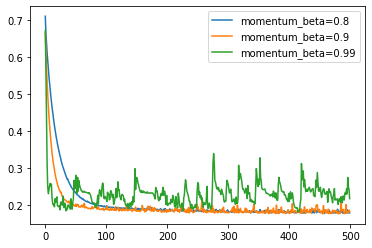

In [16]:
filtered_models = [
    model
    for model in models
    if model["hidden_layers"] == [32, 32] and model["l2_value"] == 0.01
]
for model in filtered_models:
    plt.plot(
        model["results"].history["loss"],
        label="momentum_beta={}".format(model["momentum_beta"]),
    )
plt.legend()
plt.show()

We can see that the model that converged fast and remained stable was with beta = 0.9.

### Study: Effect of L2 values
Fixing hidden_layers = [32, 32] and momentum beta = 0.9, ploting the loss by epoch of different L2 values:

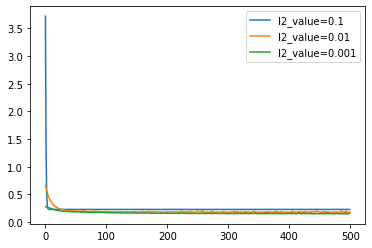

In [17]:
filtered_models = [
    model
    for model in models
    if model["hidden_layers"] == [32, 32] and model["momentum_beta"] == 0.9
]
for model in filtered_models:
    plt.plot(
        model["results"].history["loss"],
        label="l2_value={}".format(model["l2_value"]),
    )
plt.legend()
plt.show()

For this dataset we can see that all of 3 values of L2 ended up very close, with the 0.01 and 0.001 sightly better